In [2]:
import os, re, json, random, io, itertools
import numpy as np, pandas as pd
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

np.set_printoptions(suppress=True, linewidth=140)
tf.random.set_seed(42); np.random.seed(42); random.seed(42)

print("TF:", tf.__version__)
print("Devices:", tf.config.list_physical_devices())

# Keep float32 (easier int8 conversion later)
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy("float32")
    print("Mixed precision:", mixed_precision.global_policy())
except Exception as e:
    print("Mixed precision setup skipped:", e)

TF: 2.18.0
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mixed precision: <DTypePolicy "float32">


In [3]:
# downloads and extracts to ./data/dataset_v2
!python ./data/fetch_dataset.py --extract_to dataset_v2

Downloading...
From (original): https://drive.google.com/uc?id=15zLaP5V3ltR6qro98u492eqFBSeSO-0m
From (redirected): https://drive.google.com/uc?id=15zLaP5V3ltR6qro98u492eqFBSeSO-0m&confirm=t&uuid=92829282-9035-4ed2-ba75-4ca27752a8d9
To: /home/pranavdm/UMD/Sem-3/ENEE719D/Gitlab/project-1/Fall_25/ENEE719D_Fall25_Kumar_Deshaku_ANV_Ahmad/HuGaDB v2.zip
100%|██████████████████████████████████████| 88.8M/88.8M [00:02<00:00, 35.2MB/s]
ZIP contains: ['HuGaDB_v2_various_01_07.txt', 'HuGaDB_v2_various_01_08.txt', 'HuGaDB_v2_various_01_09.txt', 'HuGaDB_v2_various_01_10.txt', 'HuGaDB_v2_various_01_11.txt', 'HuGaDB_v2_various_01_12.txt', 'HuGaDB_v2_various_01_13.txt', 'HuGaDB_v2_various_01_14.txt', 'HuGaDB_v2_various_01_15.txt', 'HuGaDB_v2_various_01_16.txt', 'HuGaDB_v2_various_02_00.txt', 'HuGaDB_v2_various_02_01.txt', 'HuGaDB_v2_various_02_02.txt', 'HuGaDB_v2_various_02_03.txt', 'HuGaDB_v2_various_02_04.txt', 'HuGaDB_v2_various_02_05.txt', 'HuGaDB_v2_various_02_06.txt', 'HuGaDB_v2_various_03_00.tx

In [4]:
EXTRACT_DIR = "./data/dataset_v2"
print("EXTRACT_DIR =", EXTRACT_DIR)
print("TXT files found:", len(glob(os.path.join(EXTRACT_DIR, '**', '*.txt'), recursive=True)))

EXTRACT_DIR = ./data/dataset_v2
TXT files found: 364


In [5]:
%%writefile hugadb_v2_pipeline.py
import numpy as np, pandas as pd

# Our 4 signals (paper’s left-limb subset)
CANDIDATE_SETS = [
    ["acc_ls_x","acc_ls_z","gyro_ls_y","gyro_lf_y"],  # long names
    ["ls_ax","ls_az","ls_gy","lf_gy"],               # short aliases
]

def read_and_select(path):
    dfH = pd.read_csv(path, sep=r"[\s,]+", engine="python", header=0, comment="#")
    dfH.columns = [c.strip().lower() for c in dfH.columns]
    cols = set(dfH.columns)
    for cand in CANDIDATE_SETS:
        if all(c in cols for c in cand):
            out = dfH[cand].astype("float32").dropna()
            if cand == ["ls_ax","ls_az","ls_gy","lf_gy"]:
                out.columns = ["acc_ls_x","acc_ls_z","gyro_ls_y","gyro_lf_y"]
            return out
    raise RuntimeError(f"Required columns not found in {path}")

def moving_average_df(df, w=3):
    out = df.copy()
    k = np.ones(w, dtype=np.float32)/float(w)
    for c in out.columns:
        x = out[c].astype("float32").values
        out[c] = np.convolve(x, k, mode="same")
    return out

Overwriting hugadb_v2_pipeline.py


In [6]:
import os, re, numpy as np, pandas as pd
from glob import glob
import hugadb_v2_pipeline as hp2

# Canonical label set and synonyms 
CANON = {
    "walk": ["walk","walking"],
    "run": ["run","running","jog","jogging"],
    "upstairs": ["upstairs","upstair","stair_up","stairs_up","upstairing"],
    "downstairs": ["downstairs","downstair","stair_down","stairs_down"],
    "stand": ["stand","standing","standing_up","stand_up"],
    "sit": ["sit","sitting","sitting_down","sit_down"],
    "lying": ["lying","lie","lay","laying","lying_down"],
    "cycle": ["cycle","cycling","bike","biking"],
}
WORD2CANON = {s:c for c, syns in CANON.items() for s in syns}

def canonicalize(s: str):
    s = re.sub(r"[^a-z0-9_]+", "_", s.strip().lower())
    if s in WORD2CANON: return WORD2CANON[s]
    for p in [p for p in s.split("_") if p]:
        if p in WORD2CANON: return WORD2CANON[p]
    if "stair" in s or "stairs" in s:
        if "down" in s: return "downstairs"
        if "up"   in s: return "upstairs"
    if "stand" in s: return "stand"
    if "sit"   in s: return "sit"
    if "walk"  in s: return "walk"
    if "run" in s or "jog" in s: return "run"
    if "cycle" in s or "bike" in s: return "cycle"
    if "lie" in s or "lay" in s or "lying" in s: return "lying"
    return None

def label_from_comments(path):
    try:
        with open(path, "r", errors="ignore") as f:
            head = [next(f) for _ in range(60)]
        head_text = "\n".join(head).lower()
    except Exception:
        return None
    m = re.search(r"#\s*activityid\s*[:=\s]+(\d+)", head_text, re.I)
    if m:
        id_map = {1:"walk",2:"run",3:"upstairs",4:"downstairs",5:"sit",6:"stand",7:"lying",8:"cycle"}
        return id_map.get(int(m.group(1)))
    m2 = re.search(r"#\s*activity\s+([^\n\r]+)", head_text, re.I)
    if m2:
        for t in re.split(r"[,\s]+", m2.group(1)):
            c = canonicalize(t)
            if c: return c
    m3 = re.search(r"\bact(?:ivity)?\s*[:=\s]+(\d+)", head_text, re.I)
    if m3:
        id_map = {1:"walk",2:"run",3:"upstairs",4:"downstairs",5:"sit",6:"stand",7:"lying",8:"cycle"}
        return id_map.get(int(m3.group(1)))
    return None

def label_from_dataframe(df):
    lc = [c.strip().lower() for c in df.columns]
    if "activityid" in lc:
        id_map = {1:"walk",2:"run",3:"upstairs",4:"downstairs",5:"sit",6:"stand",7:"lying",8:"cycle"}
        vid = int(pd.to_numeric(df["activityid"].iloc[0], errors="coerce"))
        return id_map.get(vid)
    if "activity" in lc:
        return canonicalize(str(df["activity"].iloc[0]))
    return None

def label_from_path(path):
    base = os.path.basename(path)
    stem = os.path.splitext(base)[0].lower()
    parents = [p.lower() for p in os.path.normpath(path).split(os.sep)][-4:]
    candidates = parents + re.split(r"[_\W]+", stem)
    for token in candidates:
        c = canonicalize(token)
        if c: return c
    return None

def infer_label(path):
    lbl = label_from_comments(path)
    if lbl: return lbl
    try:
        dfH = pd.read_csv(path, sep=r"[\s,]+", engine="python", header=0, comment=None)
        lbl = label_from_dataframe(dfH)
        if lbl: return lbl
    except Exception:
        pass
    return label_from_path(path)

In [7]:
from collections import Counter

TXT = sorted(glob(os.path.join(EXTRACT_DIR, "**", "*.txt"), recursive=True))
pairs, unlabeled = [], []

for p in TXT:
    lbl = infer_label(p)
    if lbl is None:
        unlabeled.append(p); continue
    try:
        df4 = hp2.read_and_select(p)
    except Exception:
        try:
            dfH = pd.read_csv(p, sep=r"[\s,]+", engine="python", header=0, comment=None)
            dfH.columns = [c.strip().lower() for c in dfH.columns]
            df4 = dfH[[c for c in dfH.columns if c in ["acc_ls_x","acc_ls_z","gyro_ls_y","gyro_lf_y"]]].astype("float32")
            if df4.shape[1] != 4: continue
        except Exception:
            unlabeled.append(p); continue
    if len(df4) >= 400:
        pairs.append((df4.reset_index(drop=True), lbl, p))

print("files usable:", len(pairs))
print("label counts:", Counter([lbl for _, lbl, _ in pairs]))
print("\nSample unlabeled files (first 5):")
for q in unlabeled[:5]: print("  ", q)

assert len(pairs) >= 10, "Not enough labeled files—adjust synonyms in Cell 3 or inspect 'unlabeled' paths."

files usable: 357
label counts: Counter({'cycle': 223, 'sit': 75, 'walk': 58, 'upstairs': 1})

Sample unlabeled files (first 5):
   ./data/dataset_v2/HuGaDB_v2_various_06_19.txt
   ./data/dataset_v2/HuGaDB_v2_various_06_21.txt
   ./data/dataset_v2/HuGaDB_v2_various_16_00.txt
   ./data/dataset_v2/HuGaDB_v2_various_17_23.txt


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Windowing (longer context + dense stride)
N_IN   = 40     # 30–60 also fine
FEATS  = 4
STRIDE = 2

X_list, y_list, fileids = [], [], []
for file_id, (df, lbl, path) in enumerate(pairs):
    df_ma = hp2.moving_average_df(df, w=3)
    V = df_ma.values.astype("float32")
    for i in range(0, len(V)-N_IN, STRIDE):
        X_list.append(V[i:i+N_IN, :])
        y_list.append(lbl)
        fileids.append(file_id)

X_all   = np.array(X_list, dtype=np.float32)
labels  = np.array(y_list)
fileids = np.array(fileids, dtype=np.int32)

classes = sorted(sorted(set(labels)))
cls2id  = {c:i for i,c in enumerate(classes)}
y_id    = np.array([cls2id[s] for s in labels], dtype=np.int32)
NUM_CLASSES = len(classes)
print("X_all:", X_all.shape, "classes:", classes)

# Stratified window-level split
X_tmp, X_test, y_tmp, y_test, fid_tmp, fid_test = train_test_split(
    X_all, y_id, fileids, test_size=0.2, stratify=y_id, random_state=42
)
X_train, X_val, y_train, y_val, fid_train, fid_val = train_test_split(
    X_tmp, y_tmp, fid_tmp, test_size=0.2, stratify=y_tmp, random_state=42
)

# Z-score with train stats only
scaler = StandardScaler()
scaler.fit(X_train.reshape((-1, FEATS)))
def scale_3d(X):
    s = scaler.transform(X.reshape((-1, FEATS))).astype(np.float32)
    return s.reshape((-1, N_IN, FEATS))

X_train_s = scale_3d(X_train); X_val_s = scale_3d(X_val); X_test_s = scale_3d(X_test)

# Class weights (to mitigate imbalance)
cw = compute_class_weight('balanced', classes=np.arange(NUM_CLASSES), y=y_train)
class_weight = {i: float(w) for i,w in enumerate(cw)}
print("class weights:", class_weight)

# tf.data with on-the-fly augmentation
AUTO  = tf.data.AUTOTUNE
BATCH = 1024

@tf.function
def aug_batch(x, y):
    noise = tf.random.normal(tf.shape(x), mean=0.0, stddev=0.02)
    x = x + noise
    scale = tf.random.uniform([tf.shape(x)[0], 1, tf.shape(x)[2]], 0.95, 1.05)
    x = x * scale
    return x, y

def make_ds(X, y, training=False):
    ds = tf.data.Dataset.from_tensor_slices((X, tf.one_hot(y, NUM_CLASSES)))
    if training:
        ds = ds.shuffle(min(200_000, len(X))).batch(BATCH).map(aug_batch, num_parallel_calls=AUTO)
    else:
        ds = ds.batch(BATCH)
    return ds.prefetch(AUTO)

ds_train = make_ds(X_train_s, y_train, training=True)
ds_val   = make_ds(X_val_s,   y_val,   training=False)
ds_test  = make_ds(X_test_s,  y_test,  training=False)

X_all: (546951, 40, 4) classes: [np.str_('cycle'), np.str_('sit'), np.str_('upstairs'), np.str_('walk')]
class weights: {0: 0.35536136310108746, 1: 1.5675288385756252, 2: 49.33032694475761, 3: 1.8948553611640395}


I0000 00:00:1761433595.573378   93934 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1187 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [ ]:
# Model builders (fixed: no time_major)
from tensorflow import keras
from tensorflow.keras import layers

def build_mlp_cls(widths=(32,16), lr=1e-3):
    """Tiny MLP baseline."""
    inp = keras.Input(shape=(N_IN, FEATS))
    x = layers.Flatten()(inp)
    for w in widths:
        x = layers.Dense(w, activation="relu")(x)
    out = layers.Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)
    m = keras.Model(inp, out, name=f"mlp_cls_{'-'.join(map(str,widths))}")
    m.compile(optimizer=keras.optimizers.Adam(lr),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
    return m


def build_dscnn_cls_stronger(base=24, lr=1e-3):
    """Depthwise-separable CNN with residual bottlenecks (TFLite friendly)."""
    inp = keras.Input(shape=(N_IN, FEATS))
    x = layers.Conv1D(base, 3, padding="same", activation="relu")(inp)

    # 3 residual DS blocks with dilations (1,2,4)
    for dil in (1, 2, 4):
        y = layers.DepthwiseConv1D(3, padding="same", dilation_rate=dil, use_bias=False)(x)
        y = layers.BatchNormalization()(y); y = layers.Activation("relu")(y)
        y = layers.Conv1D(base, 1, padding="same", use_bias=False)(y)
        y = layers.BatchNormalization()(y); y = layers.Activation("relu")(y)
        x = layers.Add()([x, y])

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(16, activation="relu")(x)
    out = layers.Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)

    m = keras.Model(inp, out, name=f"dscnn_cls_b{base}_res")
    m.compile(optimizer=keras.optimizers.Adam(lr),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
    return m


def build_dscnn_gru(base=16, gru_units=8, lr=1e-3):
    """
    DSCNN + GRU (forced non-cuDNN so it converts to TFLite builtins):
      - reset_after=False
      - implementation=1
      - recurrent_dropout=0.0
    """
    inp = keras.Input(shape=(N_IN, FEATS))
    x = layers.Conv1D(base, 3, padding="same", activation="relu")(inp)

    # DS block
    x = layers.DepthwiseConv1D(3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation("relu")(x)
    x = layers.Conv1D(base, 1, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation("relu")(x)

    x = layers.MaxPooling1D(2)(x)  # e.g., 40->20

    # Dilated DS block
    x = layers.DepthwiseConv1D(3, padding="same", dilation_rate=2, use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation("relu")(x)
    x = layers.Conv1D(max(8, base//2), 1, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation("relu")(x)

    # Non-cuDNN GRU (portable)
    x = layers.GRU(
        gru_units,
        return_sequences=False,
        reset_after=False,        # <- avoids cuDNN kernels
        implementation=1,         # <- non-fused path (TFLite friendly)
        activation="tanh",
        recurrent_activation="sigmoid",
        use_bias=True,
        dropout=0.0,
        recurrent_dropout=0.0,
        unroll=False,
    )(x)

    x = layers.Dense(16, activation="relu")(x)
    out = layers.Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)

    m = keras.Model(inp, out, name=f"dscnn_gru_b{base}_g{gru_units}_tflite")
    m.compile(optimizer=keras.optimizers.Adam(lr),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
    return m


def build_dscnn_lstm(base=16, lstm_units=8, lr=1e-3):
    """Optional DSCNN + LSTM (also TFLite friendly with implementation=1)."""
    inp = keras.Input(shape=(N_IN, FEATS))
    x = layers.Conv1D(base, 3, padding="same", activation="relu")(inp)

    x = layers.DepthwiseConv1D(3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation("relu")(x)
    x = layers.Conv1D(base, 1, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation("relu")(x)

    x = layers.MaxPooling1D(2)(x)

    x = layers.DepthwiseConv1D(3, padding="same", dilation_rate=2, use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation("relu")(x)
    x = layers.Conv1D(max(8, base//2), 1, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation("relu")(x)

    x = layers.LSTM(
        lstm_units,
        return_sequences=False,
        implementation=1,         # portable path
        activation="tanh",
        recurrent_activation="sigmoid",
        use_bias=True,
        dropout=0.0,
        recurrent_dropout=0.0,
        unroll=False,
    )(x)

    x = layers.Dense(16, activation="relu")(x)
    out = layers.Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)

    m = keras.Model(inp, out, name=f"dscnn_lstm_b{base}_l{lstm_units}_tflite")
    m.compile(optimizer=keras.optimizers.Adam(lr),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
    return m

In [ ]:
# Train, export INT8, compare (stores history)
from math import ceil
import os, io, numpy as np
import tensorflow as tf
from tensorflow import keras

def to_int8_tflite(model, Xcalib, out_path):
    # Representative dataset for full INT8 (builtins only)
    def rep_ds():
        n = min(400, len(Xcalib))
        for i in range(n):
            yield [Xcalib[i:i+1].astype(np.float32)]
    conv = tf.lite.TFLiteConverter.from_keras_model(model)
    conv.optimizations = [tf.lite.Optimize.DEFAULT]
    conv.representative_dataset = rep_ds
    conv.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    conv.inference_input_type  = tf.int8
    conv.inference_output_type = tf.int8
    tfl = conv.convert()
    with open(out_path, "wb") as f: f.write(tfl)
    return out_path, os.path.getsize(out_path)

def train_and_report(model, name, epochs=45, batch=1024, class_weight=None):
    steps_per_epoch = ceil(len(X_train_s)/batch)
    val_steps       = ceil(len(X_val_s)/batch)
    cbs = [
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5, verbose=0),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=0),
    ]
    hist = model.fit(
        ds_train.repeat(),
        validation_data=ds_val.repeat(),
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=val_steps,
        verbose=0,
        callbacks=cbs,
        class_weight=class_weight
    )

    # Window-level metrics
    tr_loss, tr_acc = model.evaluate(ds_train, verbose=0)
    va_loss, va_acc = model.evaluate(ds_val,   verbose=0)
    te_loss, te_acc = model.evaluate(ds_test,  verbose=0)
    print(f"[{name}] window acc: train={tr_acc*100:.2f}% | val={va_acc*100:.2f}% | test={te_acc*100:.2f}%")

    # TFLite INT8 export
    os.makedirs("./models", exist_ok=True)
    tfl_path = f"./models/{name}.tflite"
    _, size_bytes = to_int8_tflite(model, X_train_s, tfl_path)
    eff = float(te_acc) / max(1, size_bytes/1024)
    print(f"INT8 size = {size_bytes/1024:.1f} KB | Efficiency (Acc/KB) = {eff:.4f}")

    # File-level majority vote on TEST
    probs = model.predict(X_test_s, verbose=0)
    y_pred = np.argmax(probs, axis=1)
    from collections import defaultdict
    votes = defaultdict(list)
    for pred, fid in zip(y_pred, fid_test):
        votes[fid].append(pred)
    file_acc_n = len(votes); file_acc_correct = 0
    for fid, preds in votes.items():
        maj  = np.bincount(preds, minlength=NUM_CLASSES).argmax()
        true = np.bincount(y_test[fid_test==fid], minlength=NUM_CLASSES).argmax()
        file_acc_correct += int(maj == true)
    file_acc = file_acc_correct / max(1, file_acc_n)
    print(f"[{name}] **file-level test accuracy (majority vote)** = {file_acc*100:.2f}%")

    # Params for float32 footprint
    params = model.count_params()
    float32_bytes = params * 4

    return dict(
        name=name,
        model=model,
        history=hist.history,          # <-- stored
        test_acc=te_acc,
        file_acc=file_acc,
        int8_bytes=size_bytes,
        eff=eff,
        params=params,
        float32_bytes=float32_bytes,
        tflite=tfl_path
    )

# --------- Run candidates (NO RNNs to keep converter happy) ---------
candidates = []
candidates.append(train_and_report(build_mlp_cls((32,16)),           "mlp_cls_32-16",     epochs=35, class_weight=class_weight))
candidates.append(train_and_report(build_dscnn_cls_stronger(16),     "dscnn_cls_b16_res", epochs=40, class_weight=class_weight))
candidates.append(train_and_report(build_dscnn_cls_stronger(24),     "dscnn_cls_b24_res", epochs=45, class_weight=class_weight))
candidates.append(train_and_report(build_dscnn_cls_stronger(32),     "dscnn_cls_b32_res", epochs=45, class_weight=class_weight))

# Best by file-level accuracy (you can switch to efficiency if you prefer)
best = max(candidates, key=lambda d: d["file_acc"])
print("\nBEST by file-level accuracy:",
      best["name"],
      "| window_acc=", round(best["test_acc"]*100,2), "%",
      "| file_acc=", round(best["file_acc"]*100,2), "%",
      "| tflite KB=", round(best["int8_bytes"]/1024,1))

I0000 00:00:1761433600.493695   95315 service.cc:148] XLA service 0x7f9dac003070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761433600.493736   95315 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-10-25 19:06:40.540346: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1761433600.690687   95315 cuda_dnn.cc:529] Loaded cuDNN version 91301
2025-10-25 19:06:42.179511: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 188 bytes spill stores, 188 bytes spill loads

I0000 00:00:1761433603.513614   95315 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-10-25 19:06:46.569330: I 

[mlp_cls_32-16] window acc: train=83.41% | val=83.39% | test=83.40%
INFO:tensorflow:Assets written to: /tmp/tmp8nr5m2lq/assets


INFO:tensorflow:Assets written to: /tmp/tmp8nr5m2lq/assets


Saved artifact at '/tmp/tmp8nr5m2lq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 40, 4), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  140328017740048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140328017743888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140328017743312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140328017740432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140328017743504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140328017741008: TensorSpec(shape=(), dtype=tf.resource, name=None)


/home/pranavdm/UMD/Sem-3/ENEE719D/Gitlab/project-1/Fall_25/ENEE719D_Fall25_Kumar_Deshaku_ANV_Ahmad/.conda-env/p1g5_env/lib/python3.12/site-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1761433648.038762   93934 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1761433648.038791   93934 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-10-25 19:07:28.039632: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp8nr5m2lq
2025-10-25 19:07:28.040331: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-10-25 19:07:28.040346: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp8nr5m2lq
I0000 00:00:1761433648.046809   93934 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2025-10-25 19:07:28.0479

INT8 size = 10.4 KB | Efficiency (Acc/KB) = 0.0806
[mlp_cls_32-16] **file-level test accuracy (majority vote)** = 90.76%


2025-10-25 19:07:41.845463: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1951', 8 bytes spill stores, 8 bytes spill loads

2025-10-25 19:07:57.323963: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion', 140 bytes spill stores, 124 bytes spill loads



[dscnn_cls_b16_res] window acc: train=87.84% | val=87.82% | test=87.90%
INFO:tensorflow:Assets written to: /tmp/tmpyqvvbd0k/assets


INFO:tensorflow:Assets written to: /tmp/tmpyqvvbd0k/assets


Saved artifact at '/tmp/tmpyqvvbd0k'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 40, 4), dtype=tf.float32, name='keras_tensor_5')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  140328017752912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140328017755984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140328017746192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140328017746768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140328017754064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140328017755792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140328017745424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140328018067920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140328018069648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140328018069456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140328018069072: T

/home/pranavdm/UMD/Sem-3/ENEE719D/Gitlab/project-1/Fall_25/ENEE719D_Fall25_Kumar_Deshaku_ANV_Ahmad/.conda-env/p1g5_env/lib/python3.12/site-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1761433778.304889   93934 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1761433778.304915   93934 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-10-25 19:09:38.305104: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpyqvvbd0k
2025-10-25 19:09:38.307542: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-10-25 19:09:38.307562: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpyqvvbd0k
2025-10-25 19:09:38.330376: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-10-25 19:09:38.453830: I tensorflow

INT8 size = 25.0 KB | Efficiency (Acc/KB) = 0.0351
[dscnn_cls_b16_res] **file-level test accuracy (majority vote)** = 95.80%


2025-10-25 19:09:57.219056: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1951', 172 bytes spill stores, 172 bytes spill loads

2025-10-25 19:09:58.268444: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 826.56MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-10-25 19:10:07.800987: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1951', 216 bytes spill stores, 216 bytes spill loads

2025-10-25 19:10:13.283312: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion_1', 52 bytes

[dscnn_cls_b24_res] window acc: train=89.82% | val=88.46% | test=88.45%
INFO:tensorflow:Assets written to: /tmp/tmpbcyb1_ld/assets


INFO:tensorflow:Assets written to: /tmp/tmpbcyb1_ld/assets


Saved artifact at '/tmp/tmpbcyb1_ld'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 40, 4), dtype=tf.float32, name='keras_tensor_31')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  140320071866640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140320071867216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140320071867600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140320071869136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140320071868560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140320071866832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140320071865872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140328017745808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140320071870096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140320071868176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140328017744272: 

/home/pranavdm/UMD/Sem-3/ENEE719D/Gitlab/project-1/Fall_25/ENEE719D_Fall25_Kumar_Deshaku_ANV_Ahmad/.conda-env/p1g5_env/lib/python3.12/site-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1761433881.765172   93934 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1761433881.765223   93934 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-10-25 19:11:21.766281: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpbcyb1_ld
2025-10-25 19:11:21.769122: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-10-25 19:11:21.769145: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpbcyb1_ld
2025-10-25 19:11:21.795972: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-10-25 19:11:21.924887: I tensorflow

INT8 size = 27.9 KB | Efficiency (Acc/KB) = 0.0317
[dscnn_cls_b24_res] **file-level test accuracy (majority vote)** = 95.52%


2025-10-25 19:11:42.170236: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1951', 168 bytes spill stores, 168 bytes spill loads

2025-10-25 19:11:43.310627: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-10-25 19:11:54.009673: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1949', 20 bytes spill stores, 20 bytes spill loads

2025-10-25 19:11:54.949037: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1951', 232 bytes spill stores,

[dscnn_cls_b32_res] window acc: train=90.11% | val=87.73% | test=87.85%
INFO:tensorflow:Assets written to: /tmp/tmplh_hmn2l/assets


INFO:tensorflow:Assets written to: /tmp/tmplh_hmn2l/assets


Saved artifact at '/tmp/tmplh_hmn2l'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 40, 4), dtype=tf.float32, name='keras_tensor_57')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  140318910353232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140318910353616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140315778334544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140315778324368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140315778321104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140315778318992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140315778323792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140315778324176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140315778323024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140315778325136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140315778320144: 

/home/pranavdm/UMD/Sem-3/ENEE719D/Gitlab/project-1/Fall_25/ENEE719D_Fall25_Kumar_Deshaku_ANV_Ahmad/.conda-env/p1g5_env/lib/python3.12/site-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1761434028.458318   93934 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1761434028.459365   93934 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-10-25 19:13:48.461291: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmplh_hmn2l
2025-10-25 19:13:48.465613: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-10-25 19:13:48.465646: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmplh_hmn2l
2025-10-25 19:13:48.494844: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-10-25 19:13:48.659350: I tensorflow

INT8 size = 31.2 KB | Efficiency (Acc/KB) = 0.0282
[dscnn_cls_b32_res] **file-level test accuracy (majority vote)** = 94.12%

BEST by file-level accuracy: dscnn_cls_b16_res | window_acc= 87.9 % | file_acc= 95.8 % | tflite KB= 25.0


,name,window_acc_overall,file_acc_overall,int8_kb,float32_params,float32_bytes_kb,eff_test_acc_per_kb
1,dscnn_cls_b16_res,87.97,95.80,25.0,1844,7.2,0.0351
2,dscnn_cls_b24_res,88.55,95.80,27.9,3300,12.9,0.0317
3,dscnn_cls_b32_res,87.81,94.68,31.2,5140,20.1,0.0282
0,mlp_cls_32-16,83.48,91.32,10.4,5748,22.5,0.0806


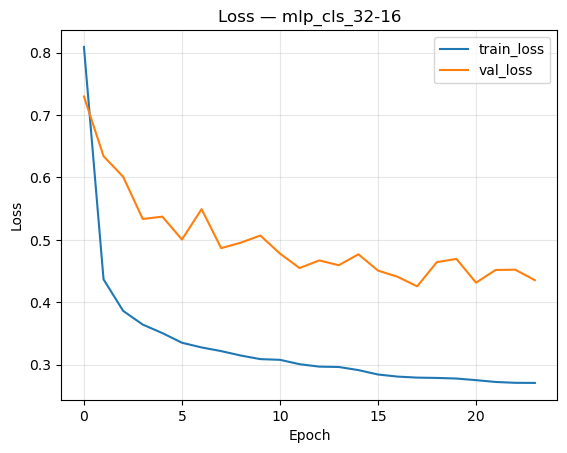

Saved plot: ./output/plots/loss_mlp_cls_32-16.png


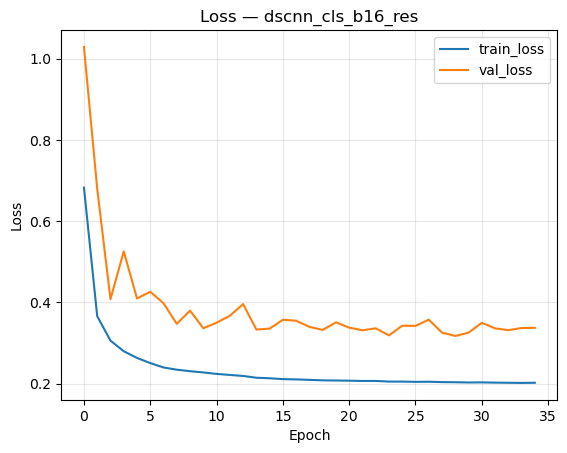

Saved plot: ./output/plots/loss_dscnn_cls_b16_res.png


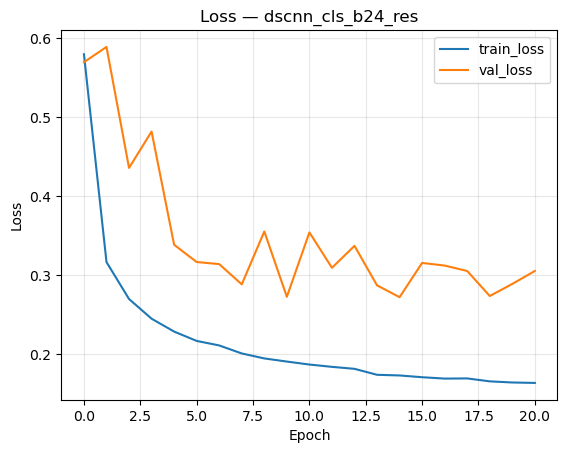

Saved plot: ./output/plots/loss_dscnn_cls_b24_res.png


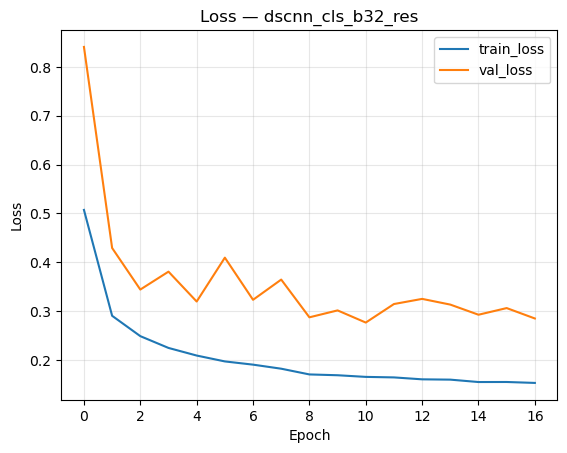

Saved plot: ./output/plots/loss_dscnn_cls_b32_res.png


Saved summary: ./output/summaries/mlp_cls_32-16_summary.txt


Saved summary: ./output/summaries/dscnn_cls_b16_res_summary.txt


Saved summary: ./output/summaries/dscnn_cls_b24_res_summary.txt


Saved summary: ./output/summaries/dscnn_cls_b32_res_summary.txt


In [ ]:
# Full reports & plots
import os, io, json, numpy as np, matplotlib.pyplot as plt
from collections import defaultdict

# 1) Overall accuracy across the entire dataset (train + val + test)
X_all   = np.concatenate([X_train_s, X_val_s, X_test_s], axis=0)
y_all   = np.concatenate([y_train,   y_val,   y_test  ], axis=0)        # integer labels
fid_all = np.concatenate([fid_train, fid_val, fid_test], axis=0)        # file ids per window
classes = list(label_to_index.keys()) if 'label_to_index' in globals() else list(range(NUM_CLASSES))

def overall_metrics(model):
    probs = model.predict(X_all, verbose=0)
    y_pred = probs.argmax(axis=1)

    # Window-level overall accuracy
    win_acc = (y_pred == y_all).mean()

    # File-level overall accuracy (majority vote per file id)
    votes = defaultdict(list)
    for p, fid in zip(y_pred, fid_all):
        votes[fid].append(p)
    file_acc_n = len(votes); file_acc_correct = 0
    # true label per file = majority of true window labels for that file
    for fid, preds in votes.items():
        maj_pred = np.bincount(preds, minlength=NUM_CLASSES).argmax()
        true_maj = np.bincount(y_all[fid_all==fid], minlength=NUM_CLASSES).argmax()
        file_acc_correct += int(maj_pred == true_maj)
    file_acc = file_acc_correct / max(1, file_acc_n)
    return float(win_acc), float(file_acc)

# 2) Print table of model sizes and overall accuracies
rows = []
for c in candidates:
    win_acc_all, file_acc_all = overall_metrics(c["model"])
    rows.append({
        "name": c["name"],
        "window_acc_overall": round(win_acc_all*100, 2),
        "file_acc_overall":   round(file_acc_all*100, 2),
        "int8_kb":            round(c["int8_bytes"]/1024, 1),
        "float32_params":     int(c["params"]),
        "float32_bytes_kb":   round(c["float32_bytes"]/1024, 1),
        "eff_test_acc_per_kb": round(c["eff"], 4),
    })

import pandas as pd
df = pd.DataFrame(rows).sort_values("file_acc_overall", ascending=False)
display(df)

# 3) Plot training & validation loss (if histories stored)
os.makedirs("./output/plots", exist_ok=True)
for c in candidates:
    hist = c.get("history", None)
    if not hist or ("loss" not in hist or "val_loss" not in hist):
        print(f"[{c['name']}] no history stored; skip loss plot.")
        continue

    plt.figure()
    plt.plot(hist["loss"], label="train_loss")
    plt.plot(hist["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"Loss — {c['name']}")
    plt.legend(); plt.grid(True, alpha=0.3)
    out_png = f"./output/plots/loss_{c['name']}.png"
    plt.savefig(out_png, dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved plot:", out_png)

# 4) Save model.summary() for each model (and optionally print)
os.makedirs("./output/summaries", exist_ok=True)
for c in candidates:
    buf = io.StringIO()
    c["model"].summary(print_fn=lambda s: buf.write(s + "\n"))
    txt = buf.getvalue()
    path = f"./output/summaries/{c['name']}_summary.txt"
    with open(path, "w") as f: f.write(txt)
    print(f"Saved summary: {path}")
    # If you want to also print the summary inline for just the best model:
    # if c["name"] == best["name"]:
    #     print(txt)

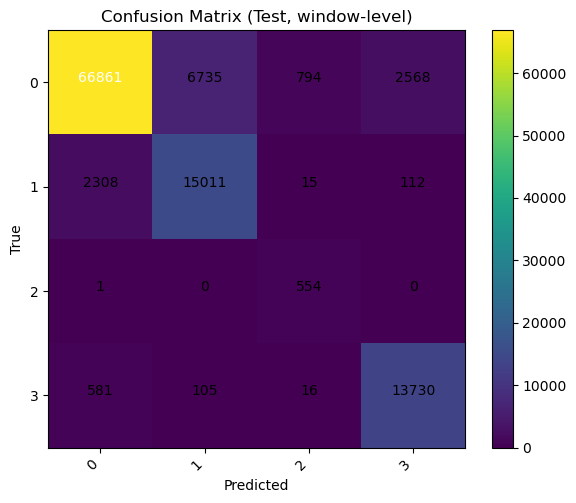

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def predict_classes(model, X, batch=1024):
    return np.argmax(model.predict(X, batch_size=batch, verbose=0), axis=1)

y_test_pred = predict_classes(best["model"], X_test_s)
cm = confusion_matrix(y_test, y_test_pred, labels=list(range(NUM_CLASSES)))

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (Test, window-level)")
plt.colorbar()
tick_marks = np.arange(NUM_CLASSES)
plt.xticks(tick_marks, classes, rotation=45, ha="right"); plt.yticks(tick_marks, classes)
th = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'), ha="center",
             color="white" if cm[i, j] > th else "black")
plt.ylabel('True'); plt.xlabel('Predicted'); plt.tight_layout(); plt.show()


Model: mlp_cls_32-16


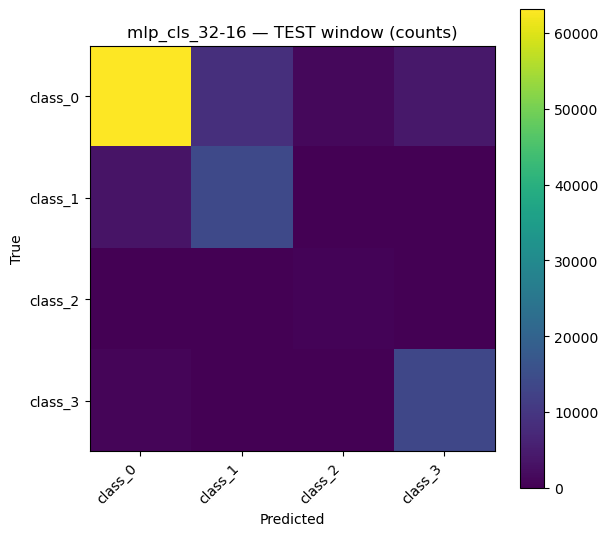

Saved: ./output/confusion_matrices/mlp_cls_32-16_TEST_window_cm.png


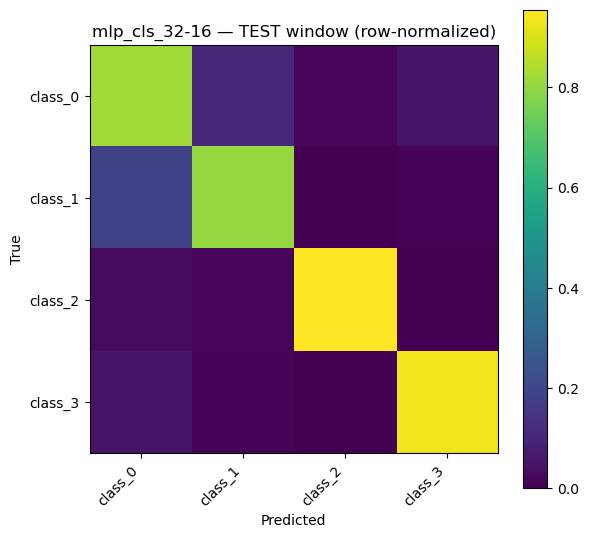

Saved: ./output/confusion_matrices/mlp_cls_32-16_TEST_window_cm_norm.png
Saved CSV: ./output/confusion_matrices/mlp_cls_32-16_TEST_window_cm_counts.csv
Saved report: ./output/confusion_matrices/mlp_cls_32-16_TEST_window_classification_report.txt
              precision    recall  f1-score   support

     class_0     0.9397    0.8207    0.8762     76958
     class_1     0.6186    0.8055    0.6998     17446
     class_2     0.2931    0.9550    0.4486       555
     class_3     0.7641    0.9350    0.8410     14432

    accuracy                         0.8340    109391
   macro avg     0.6539    0.8790    0.7164    109391
weighted avg     0.8621    0.8340    0.8412    109391



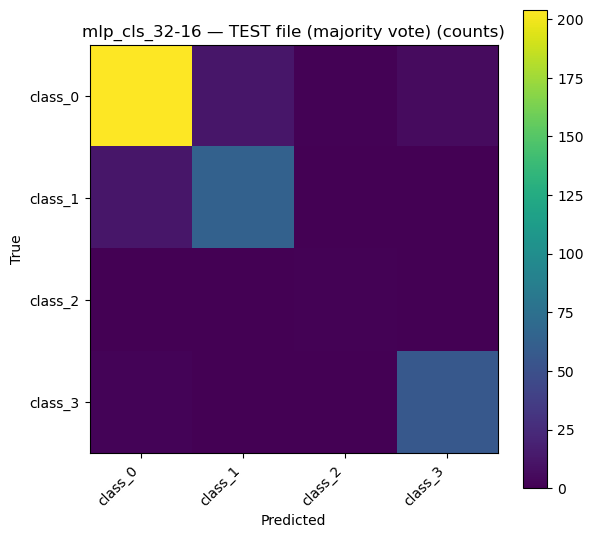

Saved: ./output/confusion_matrices/mlp_cls_32-16_TEST_file_cm.png


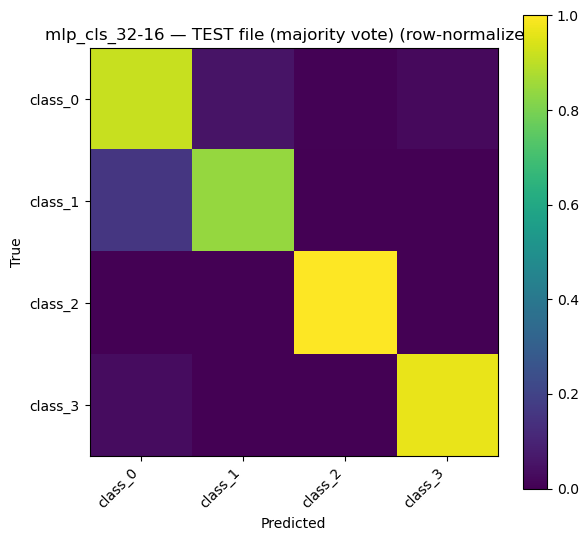

Saved: ./output/confusion_matrices/mlp_cls_32-16_TEST_file_cm_norm.png
Saved CSV: ./output/confusion_matrices/mlp_cls_32-16_TEST_file_cm_counts.csv
Saved report: ./output/confusion_matrices/mlp_cls_32-16_TEST_file_classification_report.txt
              precision    recall  f1-score   support

     class_0     0.9358    0.9148    0.9252       223
     class_1     0.8400    0.8400    0.8400        75
     class_2     0.5000    1.0000    0.6667         1
     class_3     0.9032    0.9655    0.9333        58

    accuracy                         0.9076       357
   macro avg     0.7948    0.9301    0.8413       357
weighted avg     0.9091    0.9076    0.9079       357


Model: dscnn_cls_b16_res


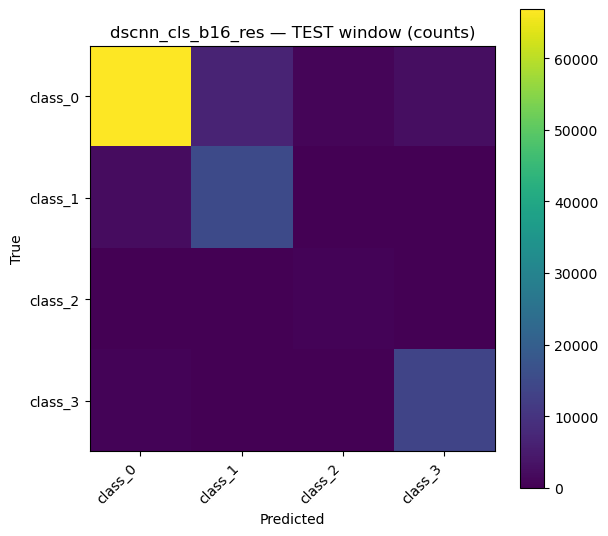

Saved: ./output/confusion_matrices/dscnn_cls_b16_res_TEST_window_cm.png


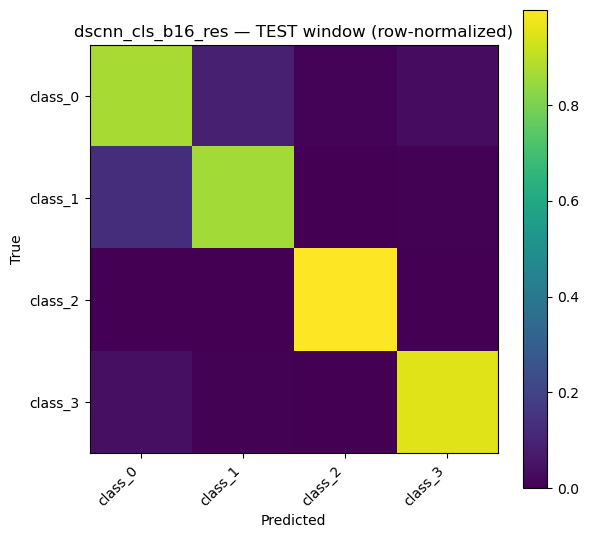

Saved: ./output/confusion_matrices/dscnn_cls_b16_res_TEST_window_cm_norm.png
Saved CSV: ./output/confusion_matrices/dscnn_cls_b16_res_TEST_window_cm_counts.csv
Saved report: ./output/confusion_matrices/dscnn_cls_b16_res_TEST_window_classification_report.txt
              precision    recall  f1-score   support

     class_0     0.9586    0.8688    0.9115     76958
     class_1     0.6870    0.8604    0.7640     17446
     class_2     0.4017    0.9982    0.5729       555
     class_3     0.8367    0.9514    0.8903     14432

    accuracy                         0.8790    109391
   macro avg     0.7210    0.9197    0.7847    109391
weighted avg     0.8963    0.8790    0.8834    109391



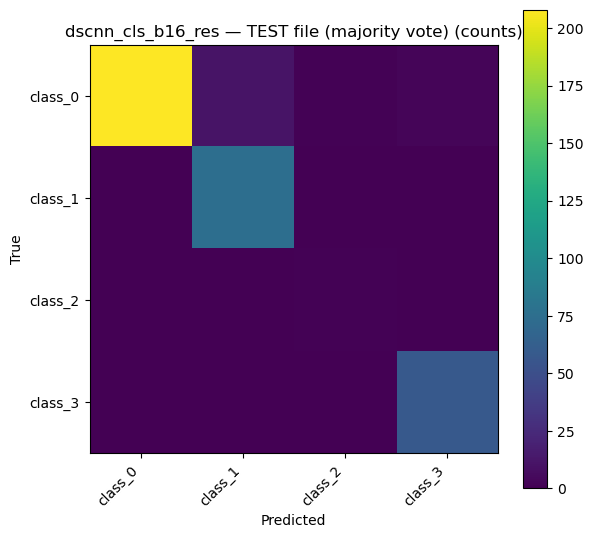

Saved: ./output/confusion_matrices/dscnn_cls_b16_res_TEST_file_cm.png


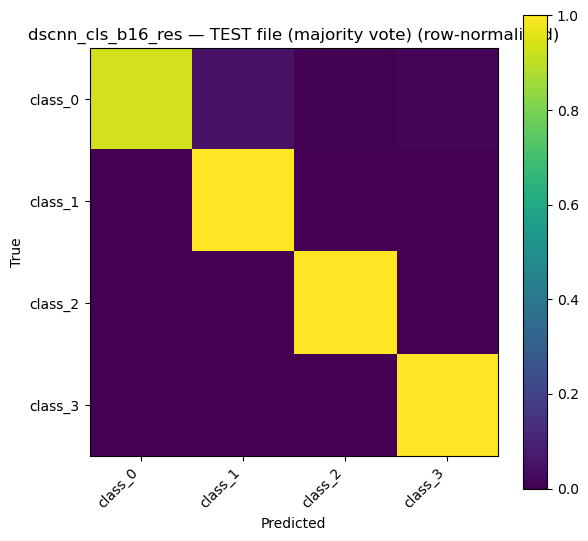

Saved: ./output/confusion_matrices/dscnn_cls_b16_res_TEST_file_cm_norm.png
Saved CSV: ./output/confusion_matrices/dscnn_cls_b16_res_TEST_file_cm_counts.csv
Saved report: ./output/confusion_matrices/dscnn_cls_b16_res_TEST_file_classification_report.txt
              precision    recall  f1-score   support

     class_0     1.0000    0.9327    0.9652       223
     class_1     0.8721    1.0000    0.9317        75
     class_2     0.5000    1.0000    0.6667         1
     class_3     0.9508    1.0000    0.9748        58

    accuracy                         0.9580       357
   macro avg     0.8307    0.9832    0.8846       357
weighted avg     0.9637    0.9580    0.9589       357


Model: dscnn_cls_b24_res


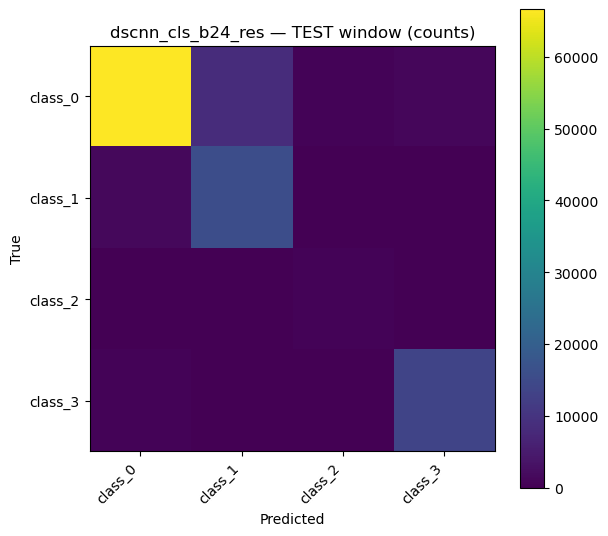

Saved: ./output/confusion_matrices/dscnn_cls_b24_res_TEST_window_cm.png


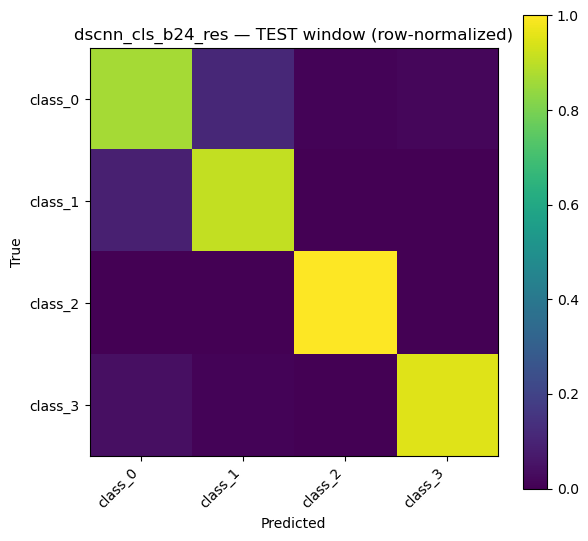

Saved: ./output/confusion_matrices/dscnn_cls_b24_res_TEST_window_cm_norm.png
Saved CSV: ./output/confusion_matrices/dscnn_cls_b24_res_TEST_window_cm_counts.csv
Saved report: ./output/confusion_matrices/dscnn_cls_b24_res_TEST_window_classification_report.txt
              precision    recall  f1-score   support

     class_0     0.9694    0.8658    0.9147     76958
     class_1     0.6481    0.9082    0.7564     17446
     class_2     0.4613    1.0000    0.6314       555
     class_3     0.9149    0.9511    0.9326     14432

    accuracy                         0.8845    109391
   macro avg     0.7484    0.9313    0.8088    109391
weighted avg     0.9084    0.8845    0.8904    109391



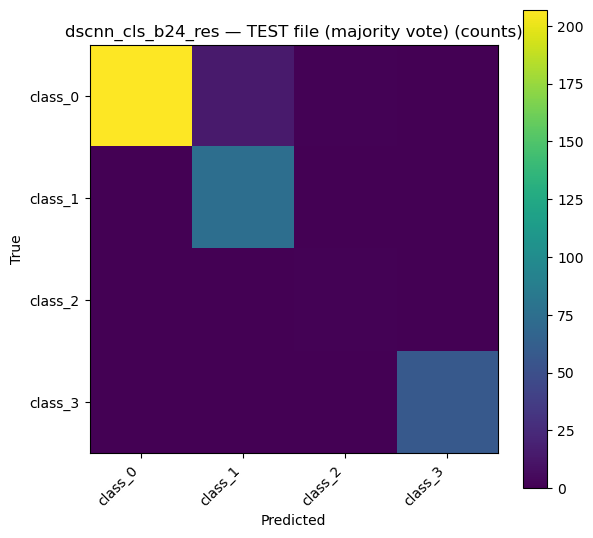

Saved: ./output/confusion_matrices/dscnn_cls_b24_res_TEST_file_cm.png


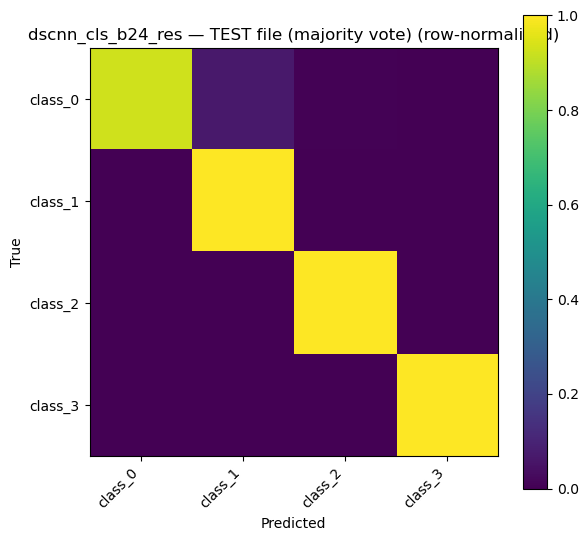

Saved: ./output/confusion_matrices/dscnn_cls_b24_res_TEST_file_cm_norm.png
Saved CSV: ./output/confusion_matrices/dscnn_cls_b24_res_TEST_file_cm_counts.csv
Saved report: ./output/confusion_matrices/dscnn_cls_b24_res_TEST_file_classification_report.txt
              precision    recall  f1-score   support

     class_0     1.0000    0.9283    0.9628       223
     class_1     0.8333    1.0000    0.9091        75
     class_2     0.5000    1.0000    0.6667         1
     class_3     1.0000    1.0000    1.0000        58

    accuracy                         0.9552       357
   macro avg     0.8333    0.9821    0.8846       357
weighted avg     0.9636    0.9552    0.9567       357


Model: dscnn_cls_b32_res


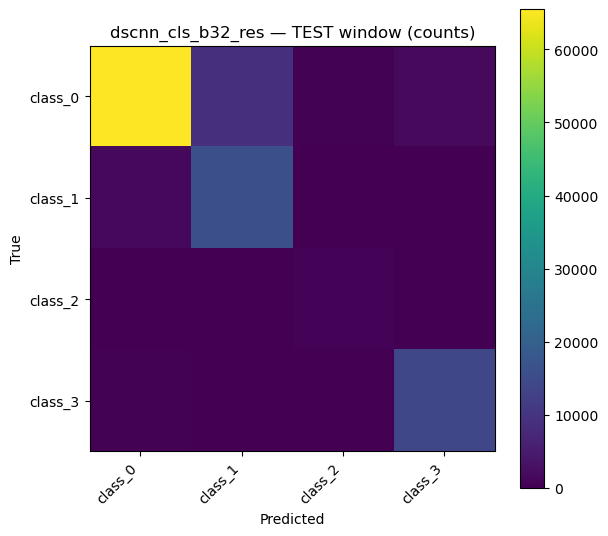

Saved: ./output/confusion_matrices/dscnn_cls_b32_res_TEST_window_cm.png


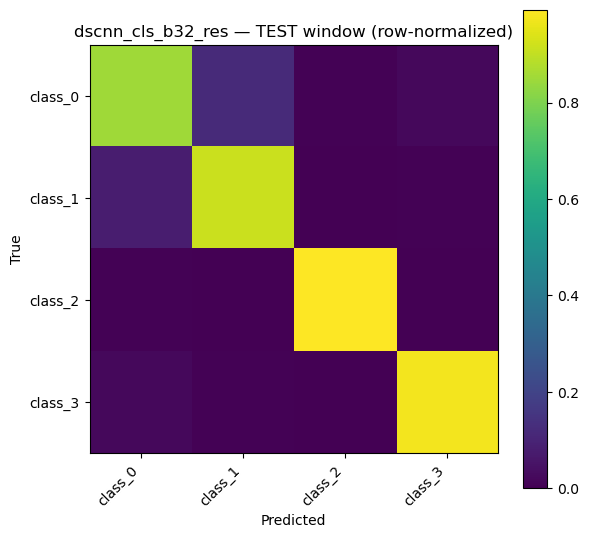

Saved: ./output/confusion_matrices/dscnn_cls_b32_res_TEST_window_cm_norm.png
Saved CSV: ./output/confusion_matrices/dscnn_cls_b32_res_TEST_window_cm_counts.csv
Saved report: ./output/confusion_matrices/dscnn_cls_b32_res_TEST_window_classification_report.txt
              precision    recall  f1-score   support

     class_0     0.9755    0.8512    0.9091     76958
     class_1     0.6326    0.9152    0.7481     17446
     class_2     0.5213    0.9928    0.6836       555
     class_3     0.8829    0.9750    0.9266     14432

    accuracy                         0.8785    109391
   macro avg     0.7531    0.9336    0.8169    109391
weighted avg     0.9063    0.8785    0.8846    109391



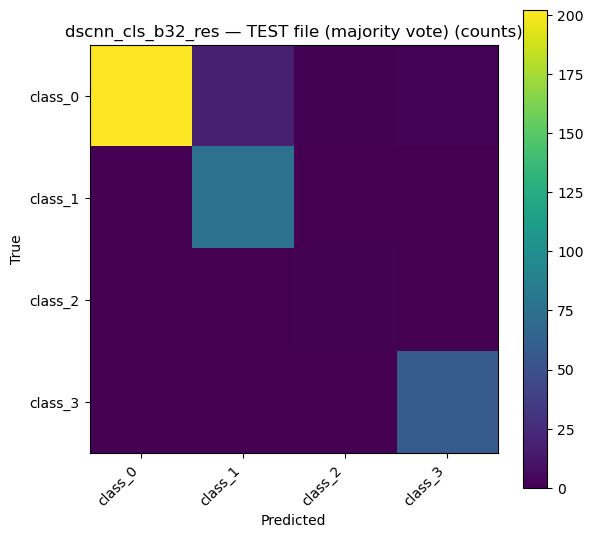

Saved: ./output/confusion_matrices/dscnn_cls_b32_res_TEST_file_cm.png


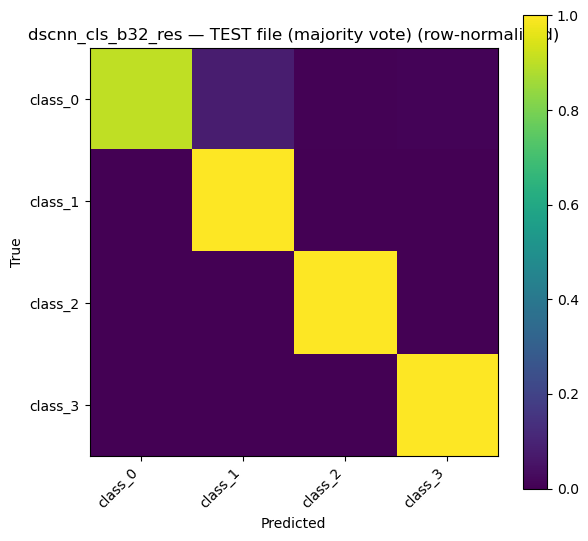

Saved: ./output/confusion_matrices/dscnn_cls_b32_res_TEST_file_cm_norm.png
Saved CSV: ./output/confusion_matrices/dscnn_cls_b32_res_TEST_file_cm_counts.csv
Saved report: ./output/confusion_matrices/dscnn_cls_b32_res_TEST_file_classification_report.txt
              precision    recall  f1-score   support

     class_0     1.0000    0.9058    0.9506       223
     class_1     0.8065    1.0000    0.8929        75
     class_2     0.5000    1.0000    0.6667         1
     class_3     0.9667    1.0000    0.9831        58

    accuracy                         0.9412       357
   macro avg     0.8183    0.9765    0.8733       357
weighted avg     0.9525    0.9412    0.9429       357


Model (overall): mlp_cls_32-16


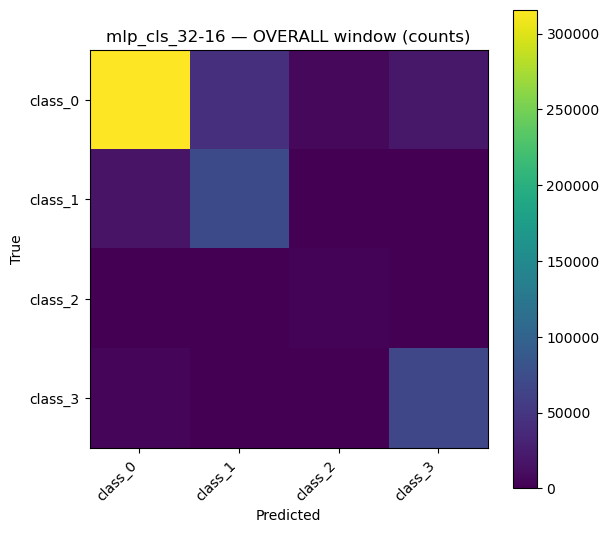

Saved: ./output/confusion_matrices/mlp_cls_32-16_OVERALL_window_cm.png


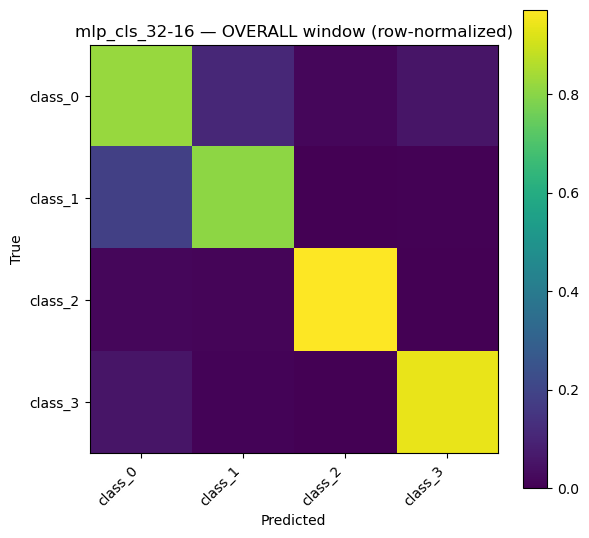

Saved: ./output/confusion_matrices/mlp_cls_32-16_OVERALL_window_cm_norm.png
Saved CSV: ./output/confusion_matrices/mlp_cls_32-16_OVERALL_window_cm_counts.csv
Saved report: ./output/confusion_matrices/mlp_cls_32-16_OVERALL_window_classification_report.txt
              precision    recall  f1-score   support

     class_0     0.9403    0.8208    0.8765    384785
     class_1     0.6219    0.8074    0.7026     87231
     class_2     0.2945    0.9708    0.4519      2773
     class_3     0.7626    0.9374    0.8410     72162

    accuracy                         0.8348    546951
   macro avg     0.6548    0.8841    0.7180    546951
weighted avg     0.8628    0.8348    0.8419    546951



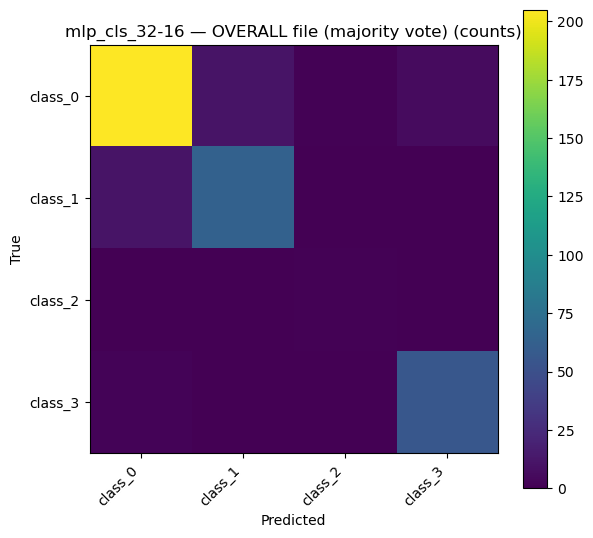

Saved: ./output/confusion_matrices/mlp_cls_32-16_OVERALL_file_cm.png


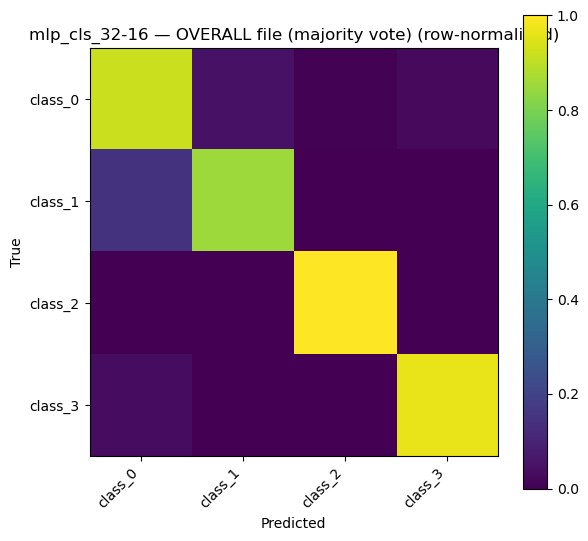

Saved: ./output/confusion_matrices/mlp_cls_32-16_OVERALL_file_cm_norm.png
Saved CSV: ./output/confusion_matrices/mlp_cls_32-16_OVERALL_file_cm_counts.csv
Saved report: ./output/confusion_matrices/mlp_cls_32-16_OVERALL_file_classification_report.txt
              precision    recall  f1-score   support

     class_0     0.9404    0.9193    0.9297       223
     class_1     0.8533    0.8533    0.8533        75
     class_2     0.5000    1.0000    0.6667         1
     class_3     0.9032    0.9655    0.9333        58

    accuracy                         0.9132       357
   macro avg     0.7992    0.9345    0.8458       357
weighted avg     0.9148    0.9132    0.9135       357


Model (overall): dscnn_cls_b16_res


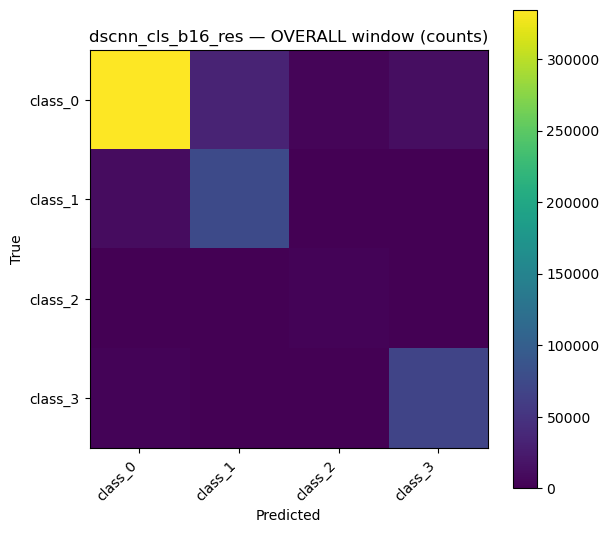

Saved: ./output/confusion_matrices/dscnn_cls_b16_res_OVERALL_window_cm.png


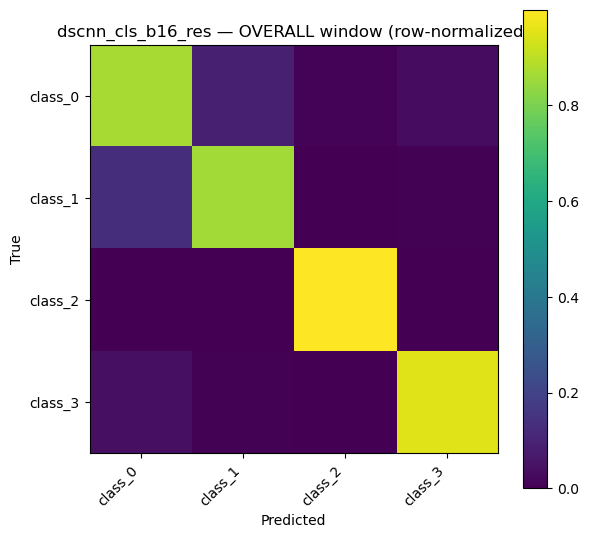

Saved: ./output/confusion_matrices/dscnn_cls_b16_res_OVERALL_window_cm_norm.png
Saved CSV: ./output/confusion_matrices/dscnn_cls_b16_res_OVERALL_window_cm_counts.csv
Saved report: ./output/confusion_matrices/dscnn_cls_b16_res_OVERALL_window_classification_report.txt
              precision    recall  f1-score   support

     class_0     0.9589    0.8693    0.9119    384785
     class_1     0.6879    0.8614    0.7649     87231
     class_2     0.4051    0.9996    0.5766      2773
     class_3     0.8380    0.9524    0.8915     72162

    accuracy                         0.8797    546951
   macro avg     0.7225    0.9207    0.7862    546951
weighted avg     0.8969    0.8797    0.8841    546951



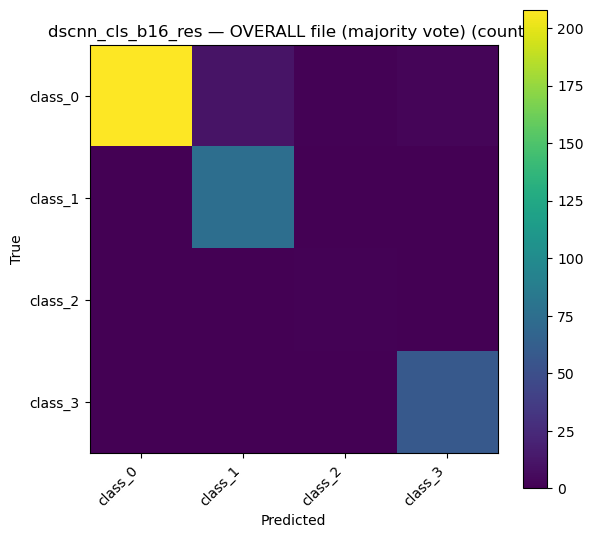

Saved: ./output/confusion_matrices/dscnn_cls_b16_res_OVERALL_file_cm.png


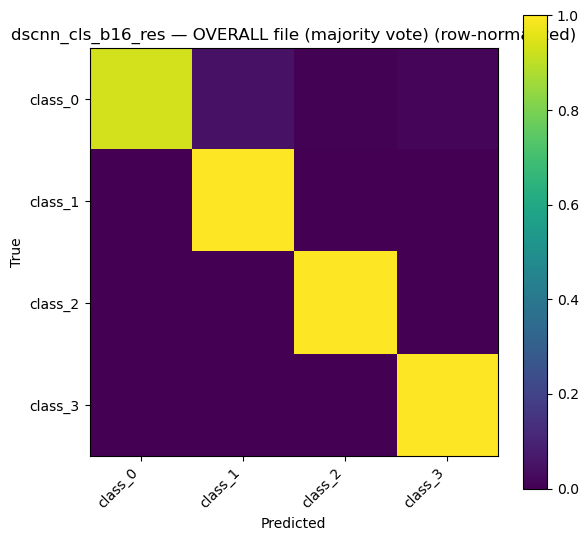

Saved: ./output/confusion_matrices/dscnn_cls_b16_res_OVERALL_file_cm_norm.png
Saved CSV: ./output/confusion_matrices/dscnn_cls_b16_res_OVERALL_file_cm_counts.csv
Saved report: ./output/confusion_matrices/dscnn_cls_b16_res_OVERALL_file_classification_report.txt
              precision    recall  f1-score   support

     class_0     1.0000    0.9327    0.9652       223
     class_1     0.8721    1.0000    0.9317        75
     class_2     0.5000    1.0000    0.6667         1
     class_3     0.9508    1.0000    0.9748        58

    accuracy                         0.9580       357
   macro avg     0.8307    0.9832    0.8846       357
weighted avg     0.9637    0.9580    0.9589       357


Model (overall): dscnn_cls_b24_res


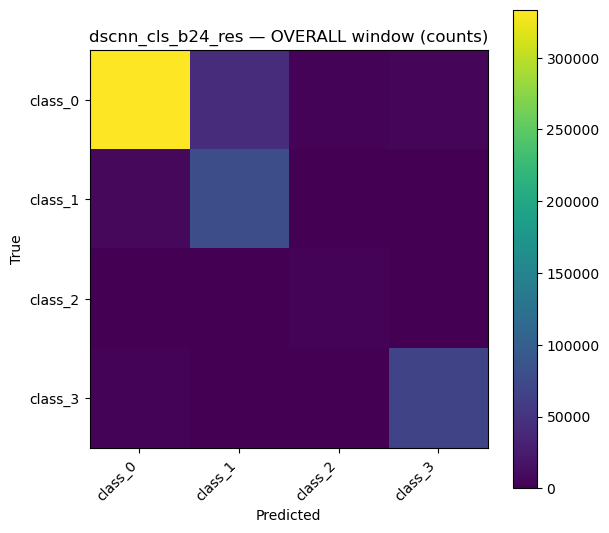

Saved: ./output/confusion_matrices/dscnn_cls_b24_res_OVERALL_window_cm.png


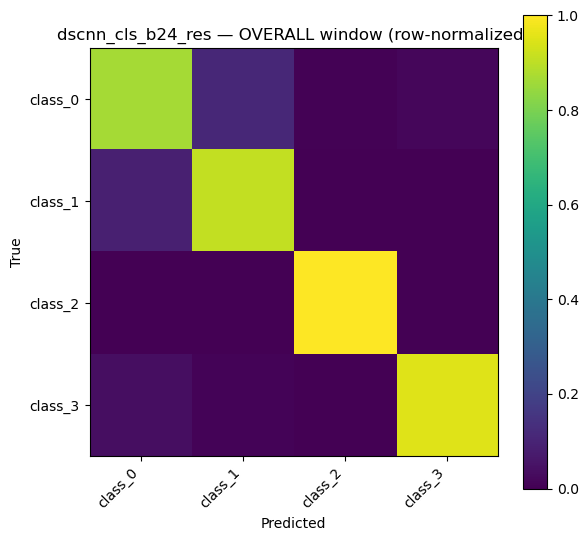

Saved: ./output/confusion_matrices/dscnn_cls_b24_res_OVERALL_window_cm_norm.png
Saved CSV: ./output/confusion_matrices/dscnn_cls_b24_res_OVERALL_window_cm_counts.csv
Saved report: ./output/confusion_matrices/dscnn_cls_b24_res_OVERALL_window_classification_report.txt
              precision    recall  f1-score   support

     class_0     0.9699    0.8666    0.9154    384785
     class_1     0.6489    0.9094    0.7574     87231
     class_2     0.4755    1.0000    0.6445      2773
     class_3     0.9158    0.9527    0.9339     72162

    accuracy                         0.8855    546951
   macro avg     0.7525    0.9322    0.8128    546951
weighted avg     0.9091    0.8855    0.8913    546951



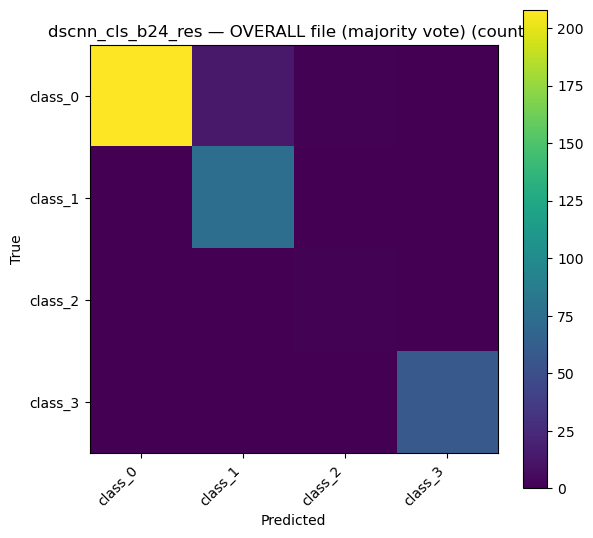

Saved: ./output/confusion_matrices/dscnn_cls_b24_res_OVERALL_file_cm.png


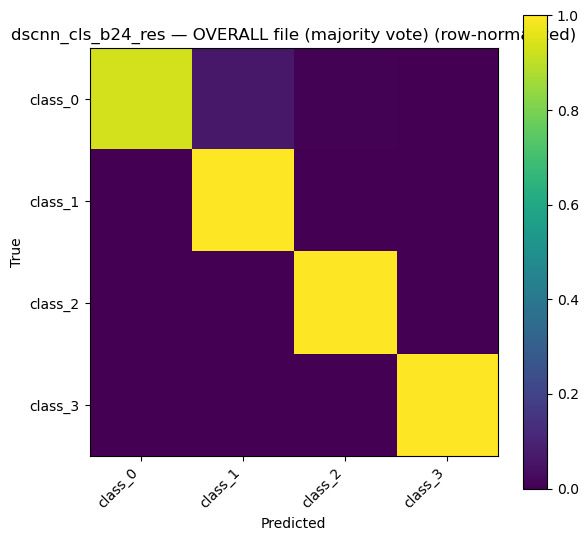

Saved: ./output/confusion_matrices/dscnn_cls_b24_res_OVERALL_file_cm_norm.png
Saved CSV: ./output/confusion_matrices/dscnn_cls_b24_res_OVERALL_file_cm_counts.csv
Saved report: ./output/confusion_matrices/dscnn_cls_b24_res_OVERALL_file_classification_report.txt
              precision    recall  f1-score   support

     class_0     1.0000    0.9327    0.9652       223
     class_1     0.8427    1.0000    0.9146        75
     class_2     0.5000    1.0000    0.6667         1
     class_3     1.0000    1.0000    1.0000        58

    accuracy                         0.9580       357
   macro avg     0.8357    0.9832    0.8866       357
weighted avg     0.9656    0.9580    0.9594       357


Model (overall): dscnn_cls_b32_res


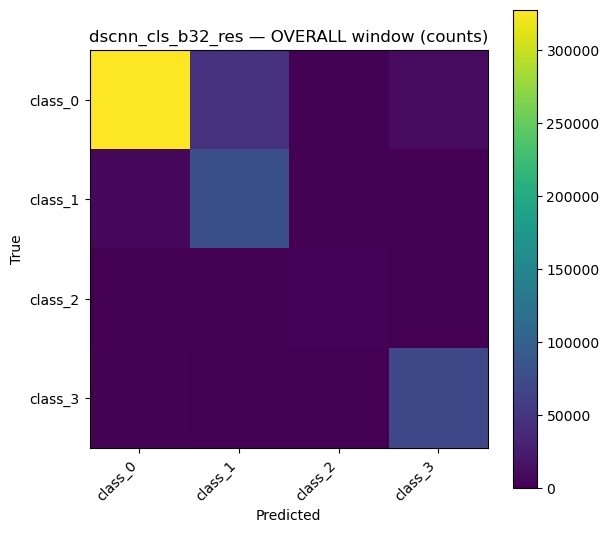

Saved: ./output/confusion_matrices/dscnn_cls_b32_res_OVERALL_window_cm.png


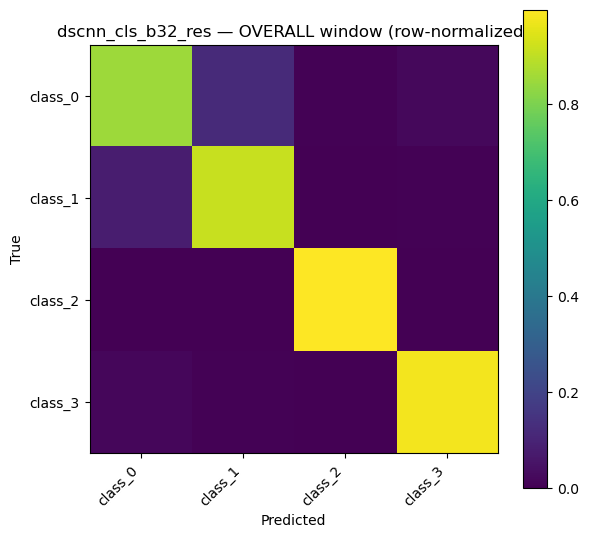

Saved: ./output/confusion_matrices/dscnn_cls_b32_res_OVERALL_window_cm_norm.png
Saved CSV: ./output/confusion_matrices/dscnn_cls_b32_res_OVERALL_window_cm_counts.csv
Saved report: ./output/confusion_matrices/dscnn_cls_b32_res_OVERALL_window_classification_report.txt
              precision    recall  f1-score   support

     class_0     0.9753    0.8508    0.9088    384785
     class_1     0.6315    0.9132    0.7466     87231
     class_2     0.5368    0.9964    0.6977      2773
     class_3     0.8816    0.9770    0.9269     72162

    accuracy                         0.8781    546951
   macro avg     0.7563    0.9344    0.8200    546951
weighted avg     0.9059    0.8781    0.8842    546951



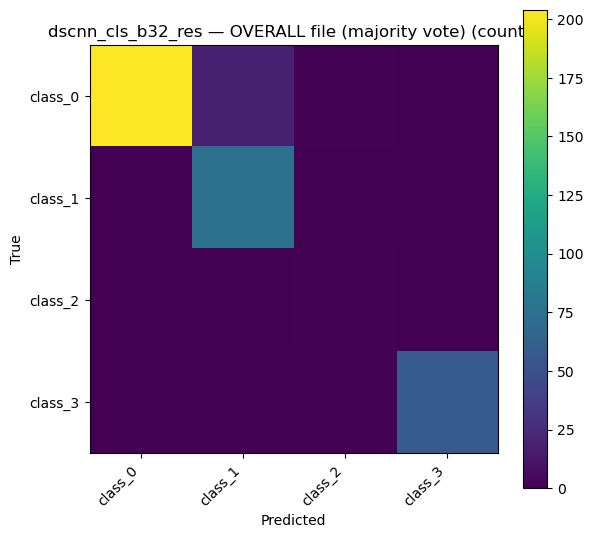

Saved: ./output/confusion_matrices/dscnn_cls_b32_res_OVERALL_file_cm.png


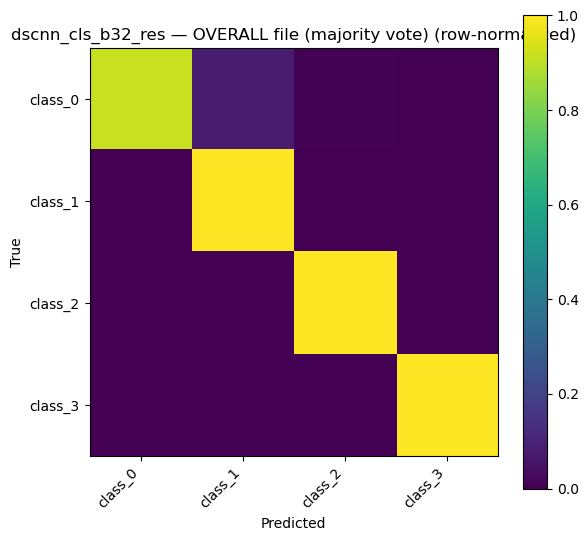

Saved: ./output/confusion_matrices/dscnn_cls_b32_res_OVERALL_file_cm_norm.png
Saved CSV: ./output/confusion_matrices/dscnn_cls_b32_res_OVERALL_file_cm_counts.csv
Saved report: ./output/confusion_matrices/dscnn_cls_b32_res_OVERALL_file_classification_report.txt
              precision    recall  f1-score   support

     class_0     1.0000    0.9148    0.9555       223
     class_1     0.8065    1.0000    0.8929        75
     class_2     0.5000    1.0000    0.6667         1
     class_3     1.0000    1.0000    1.0000        58

    accuracy                         0.9468       357
   macro avg     0.8266    0.9787    0.8788       357
weighted avg     0.9579    0.9468    0.9488       357



In [ ]:
# Confusion matrices & reports
import os, io, json, numpy as np, matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import confusion_matrix, classification_report

# Label names (index -> class string)
if 'index_to_label' in globals():
    label_names = [index_to_label[i] for i in range(NUM_CLASSES)]
elif 'label_to_index' in globals():
    # inverse from label_to_index
    inv = {v:k for k,v in label_to_index.items()}
    label_names = [inv[i] for i in range(NUM_CLASSES)]
else:
    label_names = [f"class_{i}" for i in range(NUM_CLASSES)]

os.makedirs("./output/confusion_matrices", exist_ok=True)

def file_level_preds(y_pred, fids, num_classes):
    """Majority vote per file id -> per-file predicted/true labels."""
    votes_pred = defaultdict(list)
    votes_true = defaultdict(list)
    # True labels per window must be available in the same order as fids
    return votes_pred, votes_true

def per_file_from_windows(y_pred, y_true, fids, num_classes):
    """Compute per-file predicted & true labels using majority votes."""
    votes_p = defaultdict(list)
    votes_t = defaultdict(list)
    for yp, yt, fid in zip(y_pred, y_true, fids):
        votes_p[fid].append(yp)
        votes_t[fid].append(yt)
    fids_sorted = sorted(votes_p.keys())
    y_pred_file = []
    y_true_file = []
    for fid in fids_sorted:
        pred_maj = np.bincount(votes_p[fid], minlength=num_classes).argmax()
        true_maj = np.bincount(votes_t[fid], minlength=num_classes).argmax()
        y_pred_file.append(pred_maj)
        y_true_file.append(true_maj)
    return np.array(y_pred_file), np.array(y_true_file)

def plot_cm(cm, title, out_png, labels):
    """Matplotlib confusion matrix (counts and normalized)."""
    # Counts
    plt.figure(figsize=(6.2,5.6))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title + " (counts)")
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, ha='right')
    plt.yticks(tick_marks, labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(out_png, dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved:", out_png)

    # Normalized (row-wise)
    with np.errstate(all='ignore'):
        cm_norm = cm.astype(np.float64) / np.clip(cm.sum(axis=1, keepdims=True), 1, None)
    out_png_norm = out_png.replace(".png", "_norm.png")
    plt.figure(figsize=(6.2,5.6))
    plt.imshow(cm_norm, interpolation='nearest')
    plt.title(title + " (row-normalized)")
    plt.colorbar()
    plt.xticks(tick_marks, labels, rotation=45, ha='right')
    plt.yticks(tick_marks, labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(out_png_norm, dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved:", out_png_norm)
    return cm_norm, out_png_norm

def save_cm_csv(cm, out_csv):
    import pandas as pd
    df_cm = pd.DataFrame(cm, index=label_names, columns=label_names)
    df_cm.to_csv(out_csv, index=True)
    print("Saved CSV:", out_csv)

def run_confusions_for(model_name, model, split_tag, X, y, fids):
    """Compute window-level + file-level confusion matrices & reports for a split."""
    # Window-level
    probs = model.predict(X, verbose=0)
    y_pred = probs.argmax(axis=1)
    cm_win = confusion_matrix(y, y_pred, labels=list(range(NUM_CLASSES)))

    base = f"./output/confusion_matrices/{model_name}_{split_tag}_window"
    cm_png = base + "_cm.png"
    cm_norm, _ = plot_cm(cm_win, f"{model_name} — {split_tag} window", cm_png, label_names)
    save_cm_csv(cm_win, base + "_cm_counts.csv")

    # Classification report (window)
    rep_txt = classification_report(y, y_pred, target_names=label_names, digits=4)
    rep_path = base + "_classification_report.txt"
    with open(rep_path, "w") as f: f.write(rep_txt)
    print("Saved report:", rep_path)
    print(rep_txt)

    # File-level (majority vote)
    y_pred_file, y_true_file = per_file_from_windows(y_pred, y, fids, NUM_CLASSES)
    cm_file = confusion_matrix(y_true_file, y_pred_file, labels=list(range(NUM_CLASSES)))

    base_f = f"./output/confusion_matrices/{model_name}_{split_tag}_file"
    cmf_png = base_f + "_cm.png"
    cmf_norm, _ = plot_cm(cm_file, f"{model_name} — {split_tag} file (majority vote)", cmf_png, label_names)
    save_cm_csv(cm_file, base_f + "_cm_counts.csv")

    rep_txt_f = classification_report(y_true_file, y_pred_file, target_names=label_names, digits=4)
    rep_path_f = base_f + "_classification_report.txt"
    with open(rep_path_f, "w") as f: f.write(rep_txt_f)
    print("Saved report:", rep_path_f)
    print(rep_txt_f)

# -------- Run for TEST split for every model --------
for c in candidates:
    print("\n==============================")
    print("Model:", c["name"])
    run_confusions_for(c["name"], c["model"], "TEST", X_test_s, y_test, fid_test)

# -------- Optional: ALSO run for ALL windows (overall) --------
RUN_OVERALL_TOO = True
if RUN_OVERALL_TOO:
    X_all   = np.concatenate([X_train_s, X_val_s, X_test_s], axis=0)
    y_all   = np.concatenate([y_train,   y_val,   y_test  ], axis=0)
    fid_all = np.concatenate([fid_train, fid_val, fid_test], axis=0)
    for c in candidates:
        print("\n==============================")
        print("Model (overall):", c["name"])
        run_confusions_for(c["name"], c["model"], "OVERALL", X_all, y_all, fid_all)

In [ ]:
# FOM ranking (file-level macro F1 on TEST)
# FOM = 1 / normalized_memory + normalized_f1
# where:
#   normalized_memory = model_size_kb / lowest_model_size_kb
#   normalized_f1     = model_f1 / best_model_f1
import numpy as np, pandas as pd
from collections import defaultdict
from sklearn.metrics import f1_score

def file_level_preds_from_windows(model, X, y_true_win, fids, num_classes):
    """Return per-file y_true/y_pred using majority vote over windows."""
    probs = model.predict(X, verbose=0)
    y_pred_win = probs.argmax(axis=1)
    votes_p, votes_t = defaultdict(list), defaultdict(list)
    for yp, yt, fid in zip(y_pred_win, y_true_win, fids):
        votes_p[fid].append(yp)
        votes_t[fid].append(yt)
    fids_sorted = sorted(votes_p.keys())
    y_pred_file, y_true_file = [], []
    for fid in fids_sorted:
        pred_maj = np.bincount(votes_p[fid], minlength=NUM_CLASSES).argmax()
        true_maj = np.bincount(votes_t[fid], minlength=NUM_CLASSES).argmax()
        y_pred_file.append(pred_maj); y_true_file.append(true_maj)
    return np.array(y_true_file), np.array(y_pred_file)

# Compute file-level macro-F1 for each candidate on TEST
records = []
for c in candidates:
    y_true_file, y_pred_file = file_level_preds_from_windows(
        c["model"], X_test_s, y_test, fid_test, NUM_CLASSES
    )
    f1_macro = f1_score(y_true_file, y_pred_file, average="macro", zero_division=0)
    size_kb  = c["int8_bytes"] / 1024.0
    records.append({
        "name": c["name"],
        "file_macro_f1": f1_macro,
        "int8_kb": size_kb
    })

df_fom = pd.DataFrame(records)

# Normalization terms
lowest_kb = df_fom["int8_kb"].min()
best_f1   = df_fom["file_macro_f1"].max()

# Compute normalized terms and FOM
df_fom["normalized_memory"] = df_fom["int8_kb"] / lowest_kb
df_fom["normalized_f1"]     = df_fom["file_macro_f1"] / best_f1
df_fom["FOM"]               = 1.0 / df_fom["normalized_memory"] + df_fom["normalized_f1"]

# Sort and display
df_fom = df_fom.sort_values("FOM", ascending=False).reset_index(drop=True)
display(df_fom[["name","file_macro_f1","int8_kb","normalized_memory","normalized_f1","FOM"]])

# Pick the best by FOM
best_fom_row = df_fom.iloc[0]
print(f"\nBest by FOM: {best_fom_row['name']}")
print(f"  Macro F1 (file-level TEST): {best_fom_row['file_macro_f1']:.4f}")
print(f"  Size (KB): {best_fom_row['int8_kb']:.1f}")
print(f"  normalized_memory: {best_fom_row['normalized_memory']:.4f}")
print(f"  normalized_f1:     {best_fom_row['normalized_f1']:.4f}")
print(f"  FOM:               {best_fom_row['FOM']:.4f}")

# Save results
os.makedirs("./output/fom", exist_ok=True)
out_csv = "./output/fom/results.csv"
df_fom.to_csv(out_csv, index=False)
print("Saved:", out_csv)

,name,file_macro_f1,int8_kb,normalized_memory,normalized_f1,FOM
0,mlp_cls_32-16,0.841293,10.351562,1.000000,0.951003,1.951003
1,dscnn_cls_b16_res,0.884583,25.046875,2.419623,0.999939,1.413226
2,dscnn_cls_b24_res,0.884637,27.921875,2.697358,1.000000,1.370733
3,dscnn_cls_b32_res,0.873291,31.156250,3.009811,0.987174,1.319421



Best by FOM: mlp_cls_32-16
  Macro F1 (file-level TEST): 0.8413
  Size (KB): 10.4
  normalized_memory: 1.0000
  normalized_f1:     0.9510
  FOM:               1.9510
Saved: ./output/fom/results.csv


In [ ]:
# Evaluate INT8 TFLite models (accuracy & F1)
import numpy as np, pandas as pd, os, json
from collections import defaultdict
from sklearn.metrics import f1_score, accuracy_score

def tflite_run_all(model_path, X, batch=256):
    """Run a TFLite model on X (float32), handling int8 quant IO."""
    # Load interpreter
    inter = tf.lite.Interpreter(model_path=model_path)
    inter.allocate_tensors()
    in_det  = inter.get_input_details()[0]
    out_det = inter.get_output_details()[0]
    in_idx  = in_det["index"]
    out_idx = out_det["index"]

    # Quantization params
    in_scale,  in_zp  = in_det.get("quantization", (0.0, 0))
    out_scale, out_zp = out_det.get("quantization", (0.0, 0))

    preds = []
    N = len(X)
    for start in range(0, N, batch):
        xb = X[start:start+batch].astype(np.float32)
        # Quantize input if required
        if in_det["dtype"] == np.int8:
            xb_q = np.round(xb / in_scale + in_zp).astype(np.int8)
        elif in_det["dtype"] == np.uint8:
            xb_q = np.round(xb / in_scale + in_zp).astype(np.uint8)
        else:
            xb_q = xb.astype(in_det["dtype"])

        inter.resize_tensor_input(in_idx, xb_q.shape, strict=True)
        inter.allocate_tensors()
        inter.set_tensor(in_idx, xb_q)
        inter.invoke()
        yq = inter.get_tensor(out_idx)

        # Dequantize logits for numeric stability (argmax identical either way)
        if out_det["dtype"] in (np.int8, np.uint8):
            if out_det["dtype"] == np.int8:
                y = (yq.astype(np.float32) - out_zp) * out_scale
            else:
                y = (yq.astype(np.float32) - out_zp) * out_scale
        else:
            y = yq.astype(np.float32)

        preds.append(y)
    return np.concatenate(preds, axis=0)

def file_level_from_windows(y_pred_win, y_true_win, fids, num_classes):
    """Majority vote per file -> per-file labels."""
    votes_p, votes_t = defaultdict(list), defaultdict(list)
    for yp, yt, fid in zip(y_pred_win, y_true_win, fids):
        votes_p[fid].append(yp); votes_t[fid].append(yt)
    fids_sorted = sorted(votes_p.keys())
    y_pred_file, y_true_file = [], []
    for fid in fids_sorted:
        pred_maj = np.bincount(votes_p[fid], minlength=num_classes).argmax()
        true_maj = np.bincount(votes_t[fid], minlength=num_classes).argmax()
        y_pred_file.append(pred_maj); y_true_file.append(true_maj)
    return np.array(y_true_file), np.array(y_pred_file)

rows = []
for c in candidates:
    # Float32 (from earlier)
    acc_f_win  = float(c["test_acc"])
    # We didn’t save float32 F1 before; compute now for fairness
    probs_f32  = c["model"].predict(X_test_s, verbose=0)
    pred_f32   = probs_f32.argmax(axis=1)
    f1_f_win   = f1_score(y_test, pred_f32, average="macro", zero_division=0)
    yt_f32, yp_f32 = file_level_from_windows(pred_f32, y_test, fid_test, NUM_CLASSES)
    acc_f_file = accuracy_score(yt_f32, yp_f32)
    f1_f_file  = f1_score(yt_f32, yp_f32, average="macro", zero_division=0)

    # INT8 TFLite
    probs_int8 = tflite_run_all(c["tflite"], X_test_s, batch=256)
    pred_int8  = probs_int8.argmax(axis=1)
    acc_q_win  = accuracy_score(y_test, pred_int8)
    f1_q_win   = f1_score(y_test, pred_int8, average="macro", zero_division=0)
    yt_q, yp_q = file_level_from_windows(pred_int8, y_test, fid_test, NUM_CLASSES)
    acc_q_file = accuracy_score(yt_q, yp_q)
    f1_q_file  = f1_score(yt_q, yp_q, average="macro", zero_division=0)

    rows.append({
        "name": c["name"],
        "tflite_kb": round(c["int8_bytes"]/1024, 1),

        "float_win_acc":  round(acc_f_win*100, 2),
        "float_win_f1":   round(f1_f_win*100, 2),
        "float_file_acc": round(acc_f_file*100, 2),
        "float_file_f1":  round(f1_f_file*100, 2),

        "int8_win_acc":   round(acc_q_win*100, 2),
        "int8_win_f1":    round(f1_q_win*100, 2),
        "int8_file_acc":  round(acc_q_file*100, 2),
        "int8_file_f1":   round(f1_q_file*100, 2),

        "Δ_file_acc_pp":  round((acc_q_file - acc_f_file)*100, 2),
        "Δ_file_f1_pp":   round((f1_q_file  - f1_f_file )*100, 2),
    })

df_q = pd.DataFrame(rows).sort_values("int8_file_acc", ascending=False)
display(df_q)

# (Optional) save
df_q.to_csv("./output/int8_eval_test.csv", index=False)
print("Saved: ./output/int8_eval_test.csv")

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


,name,tflite_kb,float_win_acc,float_win_f1,float_file_acc,float_file_f1,int8_win_acc,int8_win_f1,int8_file_acc,int8_file_f1,Δ_file_acc_pp,Δ_file_f1_pp
3,dscnn_cls_b32_res,31.2,87.85,81.69,94.12,87.33,89.76,81.74,95.80,88.40,1.68,1.08
2,dscnn_cls_b24_res,27.9,88.45,80.88,95.52,88.46,90.35,81.65,95.80,88.49,0.28,0.03
1,dscnn_cls_b16_res,25.0,87.90,78.47,95.80,88.46,85.97,76.64,94.40,87.45,-1.40,-1.01
0,mlp_cls_32-16,10.4,83.40,71.64,90.76,84.13,84.63,72.61,91.88,85.00,1.12,0.87


Saved: ./output/int8_eval_test.csv


In [16]:
!xxd -i ./models/mlp_cls_32-16.tflite > models/model.cc

In [17]:
# Check the test data shape
print("Test data shape:", X_test_s.shape)
print("Test labels shape:", y_test.shape)
for i in range(5):
    print(f"Sample {i} - features: {X_test_s[i]}, label: {y_test[i]}")
    

Test data shape: (109391, 40, 4)
Test labels shape: (109391,)
Sample 0 - features: [[ 7.98986703e-02 -1.42018294e+00 -7.29092658e-01 -4.13802385e-01]
 [-4.85550106e-01 -1.80487359e+00 -7.30445325e-01 -3.74441743e-01]
 [-7.18303740e-01 -2.25222516e+00 -6.95350051e-01 -2.97443032e-01]
 [-7.10308373e-01 -2.64960670e+00 -6.06334090e-01 -2.37150654e-01]
 [-3.84275675e-01 -2.97877502e+00 -4.66741741e-01 -1.76403269e-01]
 [ 1.59852341e-01 -3.20483041e+00 -3.06257576e-01 -1.39415264e-01]
 [ 8.36347699e-01 -2.98829317e+00 -1.29014805e-01 -6.64143711e-02]
 [ 1.20901990e+00 -2.75549579e+00  4.94679511e-02  4.20793816e-02]
 [ 2.43359268e-01  1.94674894e-01  1.81620345e-01  2.10442975e-01]
 [-7.50285089e-01  7.29275942e-01  2.13596940e-01  3.36098135e-01]
 [-7.64054775e-01  1.33010721e+00  2.72627771e-01  3.65318000e-01]
 [-2.65677989e-01 -6.14315629e-01  3.01222593e-01  2.92544603e-01]
 [ 3.10875654e-01 -3.32341373e-01  3.62507939e-01  1.83368281e-01]
 [-4.22522835e-02 -5.75846672e-01  2.77324706e

In [18]:
# Print the test data shape and first 5 samples
print("Test data shape:", X_test_s.shape)
print("Test labels shape:", y_test.shape)
for i in range(5):
    print(f"Sample {i} - features: {X_test_s[i]}, label: {y_test[i]}")


Test data shape: (109391, 40, 4)
Test labels shape: (109391,)
Sample 0 - features: [[ 7.98986703e-02 -1.42018294e+00 -7.29092658e-01 -4.13802385e-01]
 [-4.85550106e-01 -1.80487359e+00 -7.30445325e-01 -3.74441743e-01]
 [-7.18303740e-01 -2.25222516e+00 -6.95350051e-01 -2.97443032e-01]
 [-7.10308373e-01 -2.64960670e+00 -6.06334090e-01 -2.37150654e-01]
 [-3.84275675e-01 -2.97877502e+00 -4.66741741e-01 -1.76403269e-01]
 [ 1.59852341e-01 -3.20483041e+00 -3.06257576e-01 -1.39415264e-01]
 [ 8.36347699e-01 -2.98829317e+00 -1.29014805e-01 -6.64143711e-02]
 [ 1.20901990e+00 -2.75549579e+00  4.94679511e-02  4.20793816e-02]
 [ 2.43359268e-01  1.94674894e-01  1.81620345e-01  2.10442975e-01]
 [-7.50285089e-01  7.29275942e-01  2.13596940e-01  3.36098135e-01]
 [-7.64054775e-01  1.33010721e+00  2.72627771e-01  3.65318000e-01]
 [-2.65677989e-01 -6.14315629e-01  3.01222593e-01  2.92544603e-01]
 [ 3.10875654e-01 -3.32341373e-01  3.62507939e-01  1.83368281e-01]
 [-4.22522835e-02 -5.75846672e-01  2.77324706e

In [ ]:
# Export the exact test split for Arduino test
import os, json, numpy as np, pandas as pd

out_dir = "./output/arduino_test_data"
os.makedirs(out_dir, exist_ok=True)

# Flatten windows: (N, 40, 4) -> (N, 160)
X_flat = X_test.reshape((X_test.shape[0], -1)).astype(np.float32)
y_vec  = y_test.reshape(-1).astype(int)

# Save windows and labels
pd.DataFrame(X_flat).to_csv(f"{out_dir}/test_windows_serial.csv",
                            index=False, header=False, float_format="%.6f")
pd.DataFrame({"label": y_vec}).to_csv(f"{out_dir}/test_labels.csv", index=False)

# Label map for readability on PC script
label_map = {int(i): c for i, c in enumerate(classes)}
with open(f"{out_dir}/label_map.json","w") as f:
    json.dump(label_map, f, indent=2)

print("Wrote:")
print(" -", f"{out_dir}/test_windows_serial.csv")
print(" -", f"{out_dir}/test_labels.csv")
print(" -", f"{out_dir}/label_map.json")
print("Rows (windows):", X_flat.shape[0], "| Features per row:", X_flat.shape[1])

Wrote:
 - ./output/arduino_test_data/test_windows_serial.csv
 - ./output/arduino_test_data/test_labels.csv
 - ./output/arduino_test_data/label_map.json
Rows (windows): 109391 | Features per row: 160
